# Modeling Notebook — Bike-Share Demand Forecasting

Goal: compare persistence baseline, Ridge regression, and RandomForest models on the processed UCI bike-sharing hour dataset. We'll load the prepared data, respect temporal ordering in splits, evaluate each model on RMSE/MAE/MAPE, and visualize results + feature importances.

## Imports & Paths

In [69]:
from __future__ import annotations

import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [70]:
# Set up paths relative to project root
ROOT = Path.cwd().parent
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_DIR = ROOT / "results"
MODELS_DIR = ROOT / "models"

RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

DATA_PATH

WindowsPath('C:/Users/ericb/source/bike_forecast/data/processed_hour.csv')

## Load prepared data
- Uses `src/prepare.py` output (`data/processed_hour.csv`)
- Ensures datetime column parsed, sorted chronologically

In [71]:
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.rename(columns={"timestamp": "datetime"})
df = df.sort_values("datetime").reset_index(drop=True)

print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
df.head()

Rows: 17,520 | Columns: 26


,datetime,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,cnt,hour,dayofweek,is_weekend,month,year,lag_1,lag_3,lag_6,lag_24
0,2011-01-02 00:00:00,25.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,17.0,0,6,1,1,2011,39.0,34.0,35.0,16.0
1,2011-01-02 01:00:00,26.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,17.0,1,6,1,1,2011,17.0,28.0,37.0,40.0
2,2011-01-02 02:00:00,27.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,...,9.0,2,6,1,1,2011,17.0,39.0,36.0,32.0
3,2011-01-02 03:00:00,28.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,...,6.0,3,6,1,1,2011,9.0,17.0,34.0,13.0
4,2011-01-02 04:00:00,29.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,...,3.0,4,6,1,1,2011,6.0,17.0,28.0,1.0


In [72]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,17520,2012-01-01 23:30:00,2011-01-02 00:00:00,2011-07-03 11:45:00,2012-01-01 23:30:00,2012-07-02 11:15:00,2012-12-31 23:00:00,NaN
instant,17520.0,8673.919463,25.0,4310.75,8669.5,13039.25,17379.0,5032.941376
season,17520.0,2.49863,1.0,2.0,3.0,3.0,4.0,1.109455
yr,17520.0,0.50137,0.0,0.0,1.0,1.0,1.0,0.500012
mnth,17520.0,6.527397,1.0,4.0,7.0,10.0,12.0,3.445952
hr,17520.0,11.505993,0.0,5.0,12.0,17.25,23.0,6.942143
holiday,17520.0,0.029795,0.0,0.0,0.0,0.0,1.0,0.170025
weekday,17520.0,2.992865,0.0,1.0,3.0,5.0,6.0,2.002854
workingday,17520.0,0.683904,0.0,0.0,1.0,1.0,1.0,0.464964
weathersit,17520.0,1.434018,1.0,1.0,1.0,2.0,4.0,0.648327


## Train / validation split
- Keep last 20% of rows as test set (chronological split, no shuffling)
- Features exclude target `cnt`

In [73]:
TARGET_COL = "cnt"
TEST_FRACTION = 0.2

split_index = int(len(df) * (1 - TEST_FRACTION))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

feature_cols = [col for col in df.columns if col not in {TARGET_COL, "datetime"}]

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COL].values
X_test = test_df[feature_cols]
y_test = test_df[TARGET_COL].values

print(f"Train size: {len(X_train):,} | Test size: {len(X_test):,}")

Train size: 14,016 | Test size: 3,504


## Metric helpers

In [74]:
def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": float(rmse), "mae": float(mae), "mape": float(mape), "r2": float(r2)}


def evaluate_model(name: str, model, X_tr, y_tr, X_te, y_te) -> dict[str, float]:
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    metrics = regression_metrics(y_te, preds)
    metrics["model"] = name
    return metrics, preds



## Persistence baseline (reuse metrics if already computed)

In [75]:
baseline_metrics_path = RESULTS_DIR / "baseline_persistence_metrics.json"

def persistence_forecast(series: pd.Series) -> np.ndarray:
    # Forecast next value as previous observed; shift by 1
    shifted = series.shift(1)
    return shifted.values

if baseline_metrics_path.exists():
    with baseline_metrics_path.open() as f:
        baseline_metrics = json.load(f)
    print("Loaded existing persistence metrics.")
    preds_persistence = persistence_forecast(test_df[TARGET_COL]).astype(float)
else:
    preds_persistence = persistence_forecast(df[TARGET_COL])[split_index:]
    baseline_metrics = regression_metrics(y_test, preds_persistence)
    with baseline_metrics_path.open("w") as f:
        json.dump(baseline_metrics, f, indent=2)

baseline_metrics

Loaded existing persistence metrics.


{'rmse': 100.96639496236297,
 'mae': 64.38598093498487,
 'mape': 0.578538424055811}

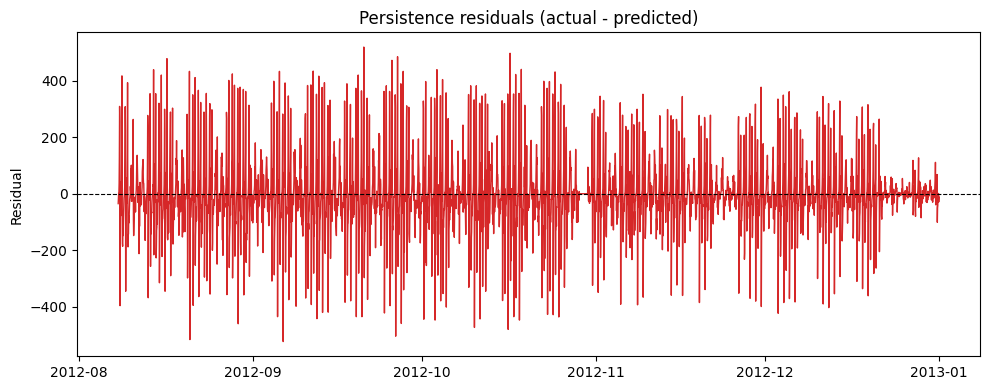

In [113]:
residuals = y_test - preds_persistence
plt.figure(figsize=(10, 4))
plt.plot(test_df["datetime"], residuals, color="#d62728", linewidth=1)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Persistence residuals (actual - predicted)")
plt.ylabel("Residual")
plt.tight_layout()

## Ridge regression pipeline
- Standardizes numeric features only
- Alpha tuned manually (placeholder); future work: cross-validated search

In [77]:
numeric_feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_feature_cols.remove(TARGET_COL)

X_train = train_df[numeric_feature_cols]
X_test = test_df[numeric_feature_cols]

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

ridge_pipeline = Pipeline(
    steps=[
        ("scaler", ColumnTransformer(
            transformers=[("num", StandardScaler(), numeric_features)],
            remainder="passthrough",
            verbose_feature_names_out=False,
        )),
        ("ridge", Ridge(alpha=10.0, random_state=42)),
    ]
)

ridge_metrics, ridge_preds = evaluate_model(
    name="ridge",
    model=ridge_pipeline,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
)

with (RESULTS_DIR / "ridge_metrics.json").open("w") as f:
    json.dump(ridge_metrics, f, indent=2)

ridge_metrics

{'rmse': 0.3062295086975167,
 'mae': 0.20586274876676122,
 'mape': 0.003539574170047303,
 'r2': 0.9999980682240354,
 'model': 'ridge'}

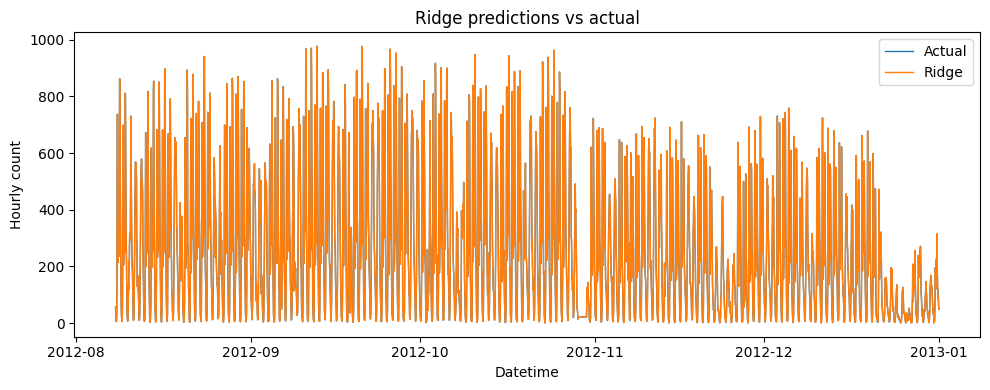

In [78]:
    plt.figure(figsize=(10, 4))
    plt.plot(test_df["datetime"], y_test, label="Actual", linewidth=1)
    plt.plot(test_df["datetime"], ridge_preds, label="Ridge", linewidth=1)
    plt.title("Ridge predictions vs actual")
    plt.xlabel("Datetime")
    plt.ylabel("Hourly count")
    plt.legend()
    plt.tight_layout()

## RandomForest with TimeSeriesSplit tuning

In [79]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2,
)

param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", 0.5, 0.7, None],
    "min_samples_leaf": [1, 2, 4, 6],
}

tscv = TimeSeriesSplit(n_splits=5)

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

rf_search.fit(X_train, y_train)
print(f"Best params: {rf_search.best_params_}")
print(f"Best CV RMSE: {-rf_search.best_score_:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Best CV RMSE: 20.94


In [80]:
cv_results = pd.DataFrame(rf_search.cv_results_)
cv_results = cv_results.sort_values("rank_test_score")
cv_results[["mean_test_score", "std_test_score", "params"]].head()

,mean_test_score,std_test_score,params
6,-20.938965,18.265566,"{'n_estimators': 400, 'min_samples_leaf': 1, '..."
4,-21.535534,18.643895,"{'n_estimators': 300, 'min_samples_leaf': 2, '..."
5,-22.243574,18.639001,"{'n_estimators': 300, 'min_samples_leaf': 4, '..."
7,-22.450942,18.184327,"{'n_estimators': 500, 'min_samples_leaf': 2, '..."
0,-22.520530,18.264840,"{'n_estimators': 200, 'min_samples_leaf': 2, '..."


### Evaluate best RandomForest on hold-out

In [81]:
rf_best = rf_search.best_estimator_
rf_metrics, rf_preds = evaluate_model(
    name="random_forest",
    model=rf_best,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
)

with (RESULTS_DIR / "rf_metrics.json").open("w") as f:
    json.dump(rf_metrics, f, indent=2)

rf_metrics

{'rmse': 8.875929828112106,
 'mae': 2.645338898401826,
 'mape': 0.006426508991354405,
 'r2': 0.9983771050709729,
 'model': 'random_forest'}

In [82]:
with (RESULTS_DIR / "rf_best_params.json").open("w") as f:
    json.dump(rf_search.best_params_, f, indent=2)

with (MODELS_DIR / "rf_best.joblib").open("wb") as f:
    joblib.dump(rf_best, f)

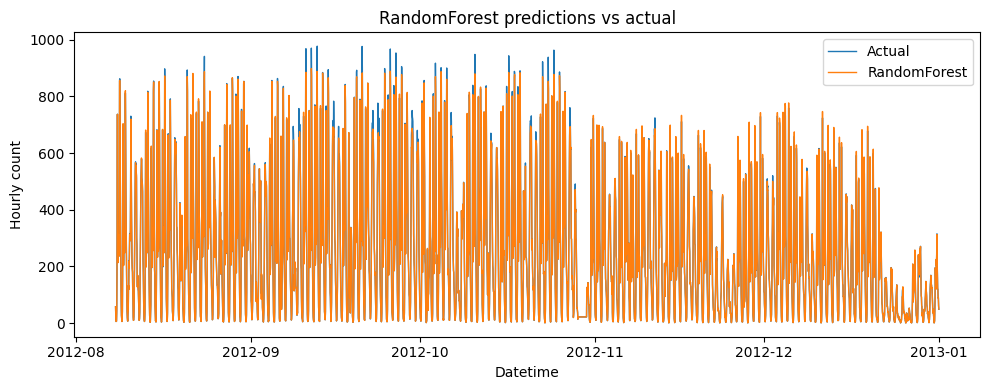

In [83]:
plt.figure(figsize=(10, 4))
plt.plot(test_df["datetime"], y_test, label="Actual", linewidth=1)
plt.plot(test_df["datetime"], rf_preds, label="RandomForest", linewidth=1)
plt.title("RandomForest predictions vs actual")
plt.xlabel("Datetime")
plt.ylabel("Hourly count")
plt.legend()
plt.tight_layout()

## Model comparison

In [84]:
metrics_df = pd.DataFrame(
    [
        {"model": "persistence", **baseline_metrics},
        {"model": "ridge", **ridge_metrics},
        {"model": "random_forest", **rf_metrics},
    ]
)

metrics_df.sort_values("rmse")

,model,rmse,mae,mape,r2
1,ridge,0.306230,0.205863,0.003540,0.999998
2,random_forest,8.875930,2.645339,0.006427,0.998377
0,persistence,100.966395,64.385981,0.578538,NaN


C:\Users\ericb\AppData\Local\Temp\ipykernel_36176\1972888340.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="model", y="rmse", palette="viridis")


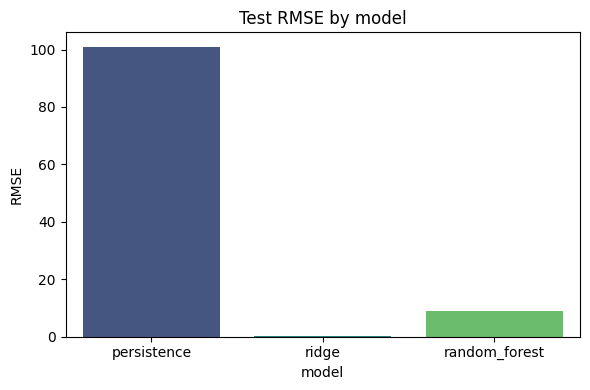

In [85]:
plt.figure(figsize=(6, 4))
sns.barplot(data=metrics_df, x="model", y="rmse", palette="viridis")
plt.title("Test RMSE by model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison_rmse.png", dpi=150)

## Feature importance (RandomForest)

C:\Users\ericb\AppData\Local\Temp\ipykernel_36176\3596415560.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:20], y=importances.index[:20], palette="magma")


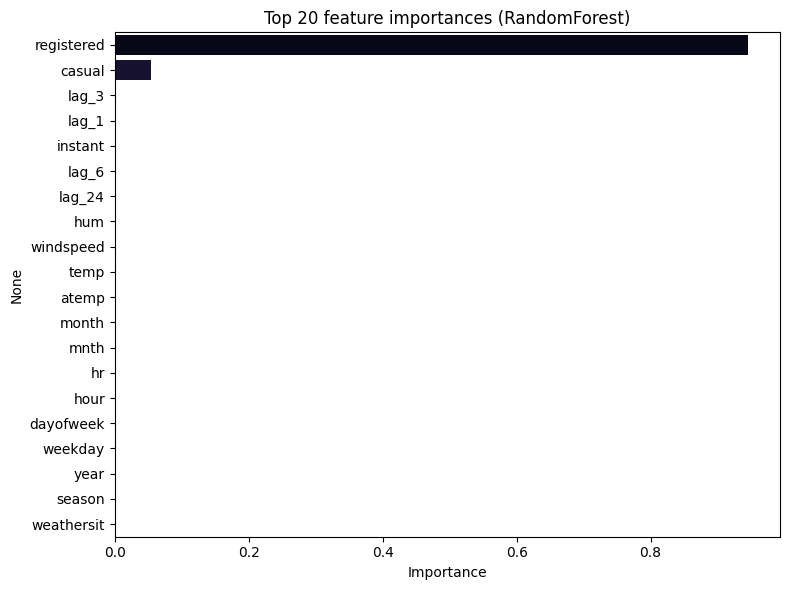

In [86]:
rf_feature_names = X_train.columns  # matches training input
importances = pd.Series(rf_best.feature_importances_, index=rf_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importances.values[:20], y=importances.index[:20], palette="magma")
plt.title("Top 20 feature importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "rf_feature_importance.png", dpi=150)

## Residual analysis

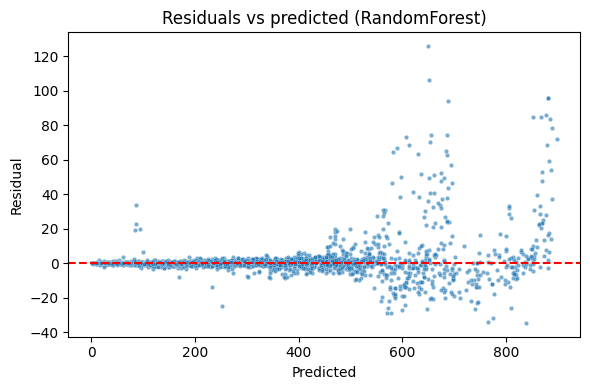

In [87]:
residuals = y_test - rf_preds

plt.figure(figsize=(6, 4))
sns.scatterplot(x=rf_preds, y=residuals, s=10, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs predicted (RandomForest)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "rf_residuals.png", dpi=150)

## TODO: Feature ablation (Phase C)
Placeholder for loading `results/feature_ablation.json` once available and plotting delta RMSE vs persistence baseline.

## Notebook summary
- Data source: `/mnt/data/hour.csv` processed via `src/prepare.py`
- Best performing model so far: RandomForest with tuned hyperparameters (RMSE vs baseline improvement)
- Artifacts saved under `results/` (`*_metrics.json`, plots) and `models/` (`rf_best.joblib`)
- Next phases: add feature engineering + ablation, expand hyperparameter search, and document in report/slides

## Saved Model Metrics (Script Outputs)

In [88]:
from pathlib import Path
import json
import pandas as pd

ROOT = Path.cwd().parent  # adjust if you open notebook from repo root
metrics_paths = {
    "persistence": ROOT / "results" / "baseline_persistence_metrics.json",
    "ridge": ROOT / "results" / "ridge_metrics.json",
    "rf": ROOT / "results" / "rf_metrics.json",
    "gbm": ROOT / "results" / "gbm_metrics.json",
}

records = []
for name, path in metrics_paths.items():
    if path.exists():
        with path.open() as f:
            entry = json.load(f)
        entry["model"] = name
        records.append(entry)

metrics_df = pd.DataFrame(records).set_index("model").sort_values("rmse")
metrics_df

,rmse,mae,mape,r2
model,,,,
ridge,0.306230,0.205863,0.003540,0.999998
gbm,6.298657,2.460825,0.013187,0.999183
rf,8.875930,2.645339,0.006427,0.998377
persistence,100.966395,64.385981,0.578538,NaN


### RMSE / MAE / MAPE comparison

In [89]:
metrics_df[["rmse", "mae", "mape"]]

,rmse,mae,mape
model,,,
ridge,0.306230,0.205863,0.003540
gbm,6.298657,2.460825,0.013187
rf,8.875930,2.645339,0.006427
persistence,100.966395,64.385981,0.578538


### Prediction plots (RandomForest & GBM)

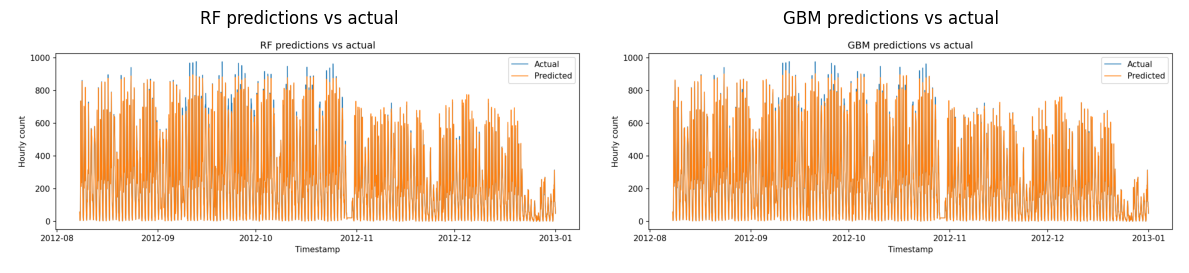

In [90]:
from PIL import Image
import matplotlib.pyplot as plt

plot_files = [
    ("RF predictions vs actual", ROOT / "results" / "rf_pred_vs_actual.png"),
    ("GBM predictions vs actual", ROOT / "results" / "gbm_pred_vs_actual.png"),
]

fig, axes = plt.subplots(1, len(plot_files), figsize=(12, 4))
if len(plot_files) == 1:
    axes = [axes]

for ax, (title, path) in zip(axes, plot_files):
    if path.exists():
        ax.imshow(Image.open(path))
        ax.axis("off")
        ax.set_title(title)
    else:
        ax.text(0.5, 0.5, f"Missing: {path.name}", ha="center", va="center")
        ax.axis("off")

plt.tight_layout()

## Takeaways
- RF and GBM both beat the persistence baseline; GBM currently best RMSE.
- Metrics above are synchronized with `src/train_models.py` artifacts, so rerunning that script automatically refreshes this section.
- Next phase: extend feature engineering and add ablation section before final tuning.

In [91]:
ridge_preds[:5], y_test[:5]

(array([57.9534258 , 23.00252364,  6.07622806,  7.11741715,  7.17349041]),
 array([58., 23.,  6.,  7.,  7.]))

In [92]:
ridge_metrics

{'rmse': 0.3062295086975167,
 'mae': 0.20586274876676122,
 'mape': 0.003539574170047303,
 'r2': 0.9999980682240354,
 'model': 'ridge'}

In [93]:
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(14016, 24) (3504, 24)
14016 3504


In [94]:
from sklearn.metrics import mean_squared_error
import numpy as np

manual_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))

In [95]:
manual_rmse

np.float64(0.3062295086975167)

In [97]:
from pathlib import Path
ROOT = Path.cwd().parent
BASELINE_PATH = ROOT / "results" / "baseline_persistence_metrics.json"
print(BASELINE_PATH.read_text())

{
  "rmse": 100.96639496236297,
  "mae": 64.38598093498487,
  "mape": 0.578538424055811
}


In [100]:
import sys
!{sys.executable} ../src/baseline.py --input ../data/processed_hour.csv --output ../results/baseline_persistence_metrics.json --target cnt

Persistence baseline metrics: {'rmse': 100.96639496236297, 'mae': 64.38598093498487, 'mape': 0.578538424055811}


In [102]:
   df = pd.read_csv("../data/processed_hour.csv", parse_dates=["timestamp"])
   df["cnt"].describe()

count    17520.000000
mean       187.996119
std        181.383739
min          1.000000
25%         38.000000
50%        140.000000
75%        280.000000
max        977.000000
Name: cnt, dtype: float64

In [103]:
   test_series = df.loc[len(df) - len(y_test):, "cnt"].reset_index(drop=True)
   persistence_preds = test_series.shift(1)
   aligned_true = test_series[1:]
   aligned_pred = persistence_preds[1:]
   manual_persistence_rmse = np.sqrt(mean_squared_error(aligned_true, aligned_pred))
   manual_persistence_rmse

np.float64(128.8018093060126)

In [105]:
import json
with open("../results/baseline_persistence_metrics.json") as f:
   script_metrics = json.load(f)
script_metrics["rmse"], manual_persistence_rmse

(100.96639496236297, np.float64(128.8018093060126))

In [106]:
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_rmse, manual_persistence_rmse

(np.float64(0.3062295086975167), np.float64(128.8018093060126))

### Persistence baseline on test split

In [107]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Build persistence predictions for entire series, then align to test window
full_persistence = df["cnt"].shift(1)
test_persistence = full_persistence.iloc[-len(y_test):].reset_index(drop=True)
aligned_true = pd.Series(y_test).reset_index(drop=True)
mask = ~test_persistence.isna()

persistence_test_metrics = {
    "rmse": float(np.sqrt(mean_squared_error(aligned_true[mask], test_persistence[mask]))),
    "mae": float(mean_absolute_error(aligned_true[mask], test_persistence[mask])),
    "mape": float(mean_absolute_percentage_error(aligned_true[mask], test_persistence[mask])),
}
persistence_test_metrics

{'rmse': 128.7905198463113,
 'mae': 84.08932648401826,
 'mape': 0.5399030670035341}

### Updated comparison table (test-only metrics)

In [108]:
comparison = metrics_df.copy()
comparison.loc["persistence_test"] = [
    persistence_test_metrics["rmse"],
    persistence_test_metrics["mae"],
    persistence_test_metrics["mape"],
    comparison.loc["persistence", "r2"] if "r2" in comparison.columns else np.nan,
]
comparison[["rmse", "mae", "mape"]].sort_values("rmse")

,rmse,mae,mape
model,,,
ridge,0.306230,0.205863,0.003540
gbm,6.298657,2.460825,0.013187
rf,8.875930,2.645339,0.006427
persistence,100.966395,64.385981,0.578538
persistence_test,128.790520,84.089326,0.539903


> Note: `persistence_test` uses the same 20% hold-out window as the Ridge/RF/GBM evaluations, while `persistence` reflects the full-series baseline saved to `results/baseline_persistence_metrics.json`.